In [5]:
import pandas as pd
import os
from datetime import datetime, timedelta
import glob

# Get the list of news files
news_files = glob.glob('data_collection/data/news/tsv/*.tsv')
print(f"Found {len(news_files)} news files")

# Function to load and process news data
def load_news_data(ticker):
    news_path = f'data_collection/data/news/tsv/{ticker}.tsv'
    if os.path.exists(news_path):
        news_df = pd.read_csv(news_path, sep='\t')
        # Convert published_utc to date
        news_df['date'] = pd.to_datetime(news_df['published_utc']).dt.date
        return news_df
    return None

# Function to load trades data
def load_trades_data(ticker):
    trades_path = f'data_collection/data/trades/tsv/{ticker}.tsv'
    if os.path.exists(trades_path):
        trades_df = pd.read_csv(trades_path, sep='\t')
        trades_df['date'] = pd.to_datetime(trades_df['date']).dt.date
        return trades_df
    return None

# Function to create combined dataframe with sentiment counts
def create_combined_df(ticker, day_offset=0):
    trades_df = load_trades_data(ticker)
    news_df = load_news_data(ticker)
    
    if trades_df is None or news_df is None:
        return None
    
    # Create a new dataframe to store the combined data
    combined_df = trades_df.copy()
    
    # Initialize sentiment columns
    combined_df['positive'] = 0
    combined_df['neutral'] = 0
    combined_df['negative'] = 0
    combined_df['culmination'] = 0
    
    # For each date in the trades dataframe, get the sentiment counts from the news dataframe
    for idx, row in combined_df.iterrows():
        trade_date = row['date']
        if day_offset > 0:
            # Look at news from earlier days based on the offset
            news_date = trade_date - timedelta(days=day_offset)
        else:
            news_date = trade_date

        # If the news date predates 2024-07-02 then drop this row
        if news_date < datetime.strptime('2024-07-02', '%Y-%m-%d').date():
            combined_df.drop(idx, inplace=True)
            continue
            
        # Filter news for the specific date
        day_news = news_df[news_df['date'] == news_date]
        
        # Count sentiment values
        positive_count = len(day_news[day_news['sentiment'] == 'positive'])
        neutral_count = len(day_news[day_news['sentiment'] == 'neutral'])
        negative_count = len(day_news[day_news['sentiment'] == 'negative'])
        
        # Calculate culmination (positive impact - negative impact)
        culmination = positive_count - negative_count
        
        # Update the combined dataframe
        combined_df.at[idx, 'positive'] = positive_count
        combined_df.at[idx, 'neutral'] = neutral_count
        combined_df.at[idx, 'negative'] = negative_count
        combined_df.at[idx, 'culmination'] = culmination
    
    # Make the index the date before returning the finalized df
    combined_df.set_index('date', inplace=True)
    return combined_df

# Create the combined dataframes with different day offsets
def create_all_dataframes(ticker):
    data_variants = {
        'same_day': create_combined_df(ticker, day_offset=0),
        '1day': create_combined_df(ticker, day_offset=1),
        '2day': create_combined_df(ticker, day_offset=2),
        '3day': create_combined_df(ticker, day_offset=3),
        '4day': create_combined_df(ticker, day_offset=4)
    }
    return data_variants

# Get the list of all tickers from the filenames
tickers = [os.path.basename(file).split('.')[0] for file in news_files]

# Process all tickers
all_data = {}
for ticker in tickers:
    all_data[ticker] = create_all_dataframes(ticker)

print(f"Created combined dataframes for {len(all_data)} tickers with 5 variants each")

Found 26 news files
Created combined dataframes for 26 tickers with 5 variants each


In [6]:
import pickle

# Save the all_data dictionary to a pickle file
with open('all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)

In [2]:
import pickle

# Load the saved data
all_data = None
with open('all_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
    all_data = loaded_data

Processing AMZN...


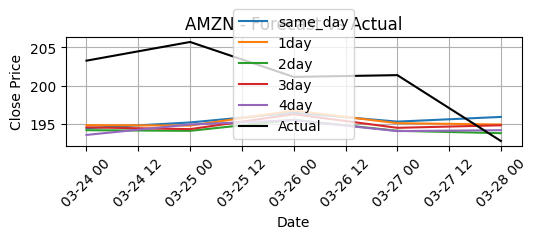

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Define the forecast period
test_start = datetime.strptime('2025-03-24', '%Y-%m-%d').date()
test_end = datetime.strptime('2025-03-28', '%Y-%m-%d').date()

# Define the exogenous variables
exog_cols = ['positive', 'negative', 'neutral', 'culmination']

# Define ticker list and variants
tickers = list(all_data.keys())
variants = ['same_day', '1day', '2day', '3day', '4day']

# Create a results dataframe to store evaluation metrics
results = []

# Create a figure for each ticker
plt.figure(figsize=(20, 15))
fig_count = len(tickers)
fig_cols = 3
fig_rows = (fig_count + fig_cols - 1) // fig_cols

for ticker_idx, ticker in enumerate(tickers):
    print(f"Processing {ticker}...")
    
    # Create a subplot for this ticker
    plt.subplot(fig_rows, fig_cols, ticker_idx + 1)
    
    # Store actual values to plot later
    actual_values = None
    
    # Process each variant
    for variant in variants:
        # Get the data for this variant
        df = all_data[ticker][variant]
        
        # Make sure date is the index
        if 'date' in df.columns:
            df.set_index('date', inplace=True)
        
        # Split data into train and test
        train_data = df[df.index < test_start]
        test_data = df[(df.index >= test_start) & (df.index <= test_end)]
        
        # If test data is empty, skip this variant
        if test_data.empty:
            print(f"  No test data for {ticker} ({variant}), skipping")
            continue
            
        # Store the actual close prices for plotting
        if actual_values is None:
            actual_values = test_data['close']
        
        # Define X and y
        y_train = train_data['close']
        X_train = train_data[exog_cols]
        
        X_test = test_data[exog_cols]
        
        # Fit SARIMAX model
        model = SARIMAX(y_train, 
                       exog=X_train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        try:
            model_fit = model.fit(disp=False)
            
            # Make predictions
            predictions = model_fit.forecast(steps=len(X_test), exog=X_test)
            
            # Calculate metrics
            mse = ((predictions - test_data['close']) ** 2).mean()
            rmse = np.sqrt(mse)
            mae = (abs(predictions - test_data['close'])).mean()
            
            # Store results
            results.append({
                'Ticker': ticker,
                'Variant': variant,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            })
            
            # Plot the predictions
            plt.plot(test_data.index, predictions, label=f'{variant}')
            
        except Exception as e:
            print(f"  Error with {ticker} ({variant}): {str(e)}")
    
    # Plot the actual values
    if actual_values is not None:
        plt.plot(actual_values.index, actual_values, 'k-', label='Actual')
    
    plt.title(f'{ticker} - Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
plt.show()

# Create a results dataframe
results_df = pd.DataFrame(results)